
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive




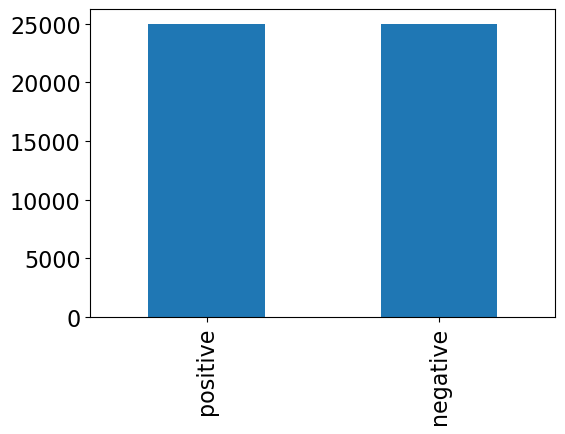

In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})


data = pd.read_csv('IMDB Dataset.csv')

# display the first 5 rows of data
print()
print(data.head(5))

print('\n')
plt.figure(figsize = (6,4))
data['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Positive review:  Smartly written, well acted, intense and suspenseful. This show lives in the real world, not as fantastical as is "24",(and I am a huge fan of 24,incidentally). It has believable characters and in many ways is much smarter than most in this genre. It tries to present both sides of Islam. So far, I have watched the first 4 episodes and find the story to be more evenly balanced. The terrorists are more complex and not one dimensional. And as a result of that balance, the terrorists become more frightening than the typical villains being portrayed in film and on television. Last but not least, the hero is truly heroic without being a cartoon. I recommend this show for anyone who is a fan of 24 and the like.


Negative review:  Drivel. Utter junk. The writers must not have read the book, or seen David Lynch's film. Not worth wasting your time.<br /><br />Longer does not make better. While more in-depth then Lynch's film, it has gross in-accuracies, and down-play's key par

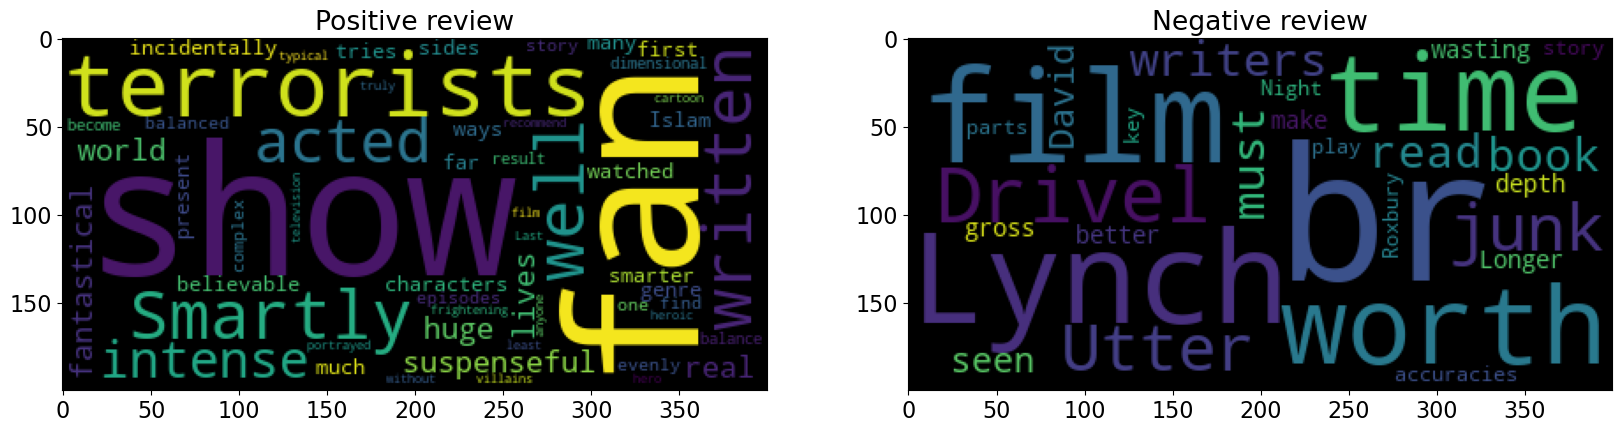

In [8]:
# Choose randomly a positive review and a negative review
ind_positive = random.choice(list(data[data['sentiment'] == 'positive'].index))
ind_negative = random.choice(list(data[data['sentiment'] == 'negative'].index))

review_positive = data['review'][ind_positive]
review_negative = data['review'][ind_negative]

print('Positive review: ', review_positive)
print('\n')
print('Negative review: ', review_negative)
print('\n')

from wordcloud import WordCloud
cloud_positive = WordCloud().generate(review_positive)
cloud_negative = WordCloud().generate(review_negative)

plt.figure(figsize = (20,15))
plt.subplot(1,2,1)
plt.imshow(cloud_positive)
plt.title('Positive review')

plt.subplot(1,2,2)
plt.imshow(cloud_negative)
plt.title('Negative review')
plt.show()

In [9]:
import re

def remove_url(text):
    url_tag = re.compile(r'https://\S+|www\.\S+')
    text = url_tag.sub(r'', text)
    return text

def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

def remove_punctuation(text): 
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text) 
    return text

def remove_special_character(text):
    special_tag = re.compile(r'[^a-zA-Z0-9\s]')
    text = special_tag.sub(r'', text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text    
    
def clean_text(text):
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_special_character(text)
    text = remove_emojis(text)
    text = text.lower()
    
    return text

In [10]:
data['processed'] = data['review'].apply(lambda x: clean_text(x))
data.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [11]:
data['Label'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

data_0 = data[data['Label'] == 0]
data_1 = data[data['Label'] == 1]

train_size = int(0.7*25000)
val_size = int(0.2*25000)

data_train = pd.concat((data_0[:train_size], data_1[:train_size]), axis = 0)
data_val = pd.concat((data_0[train_size: (train_size + val_size)], data_1[train_size:(train_size + val_size)]), axis = 0)
data_test = pd.concat((data_0[(train_size + val_size):], data_1[(train_size + val_size):]), axis = 0)

X_train, y_train = list(data_train['processed']), np.array(data_train['Label'])
X_val, y_val = list(data_val['processed']), np.array(data_val['Label'])
X_test, y_test = list(data_test['processed']), np.array(data_test['Label'])

print('Train size:', len(X_train))
print('Validation size: ', len(X_val))
print('Test size: ', len(X_test))

Train size: 35000
Validation size:  10000
Test size:  5000


In [14]:
vocab_size = 10000
max_length = 500
trunc_type = 'post'
oov_tok = 'OOV'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
token = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
token.fit_on_texts(X_train)
index_word = token.index_word

# Convert texts to sequences
train_seq = token.texts_to_sequences(X_train)
val_seq = token.texts_to_sequences(X_val)
test_seq = token.texts_to_sequences(X_test)

# Sequence padding
#Since the sequences have different lengtht, then we use padding method to put all sequences to the same length. 
#The parameter "maxlen" sets the maximum length of the output sequence. 
#    + If length of the input sequence is larger than "maxlen", then it is trunced to keep only #maxlen words, (truncating = 'pre': keep the previous part of the sequence; truncating = 'post': keep the posterior part of the sequence).
#    + If length of the input sequence is smaller than "maxlen", then 0 elements will be padded into the previous part of sequence (if padding = 'pre' - by defaut) or in the tail of the sequence (if padding = 'post').

train_pad = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
val_pad = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
test_pad = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [15]:
# Shuffle the training set
p = np.random.permutation(len(train_pad))
train_pad = train_pad[p]
y_train = y_train[p]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import plot_model

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(AveragePooling1D(pool_size = 2))
model.add(Bidirectional(LSTM(200, dropout = 0.5)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

plot_model(model, show_shapes = True)

H = model.fit(train_pad, y_train, epochs = 10, batch_size = 128,
             validation_data = (val_pad, y_val) )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/10
274/274 [==============================] - 960s 3s/step - loss: 0.5168 - accuracy: 0.7168 - val_loss: 0.3118 - val_accuracy: 0.8805
Epoch 2/10
274/274 [==============================] - 968s 4s/step - loss: 0.2697 - accuracy: 0.8957 - val_loss: 0.3135 - val_accuracy: 0.8775
Epoch 3/10
274/274 [==============================] - 982s 4s/step - loss: 0.2147 - accuracy: 0.9201 - val_loss: 0.2899 - val_accuracy: 0.8829
Epoch 4/10
274/274 [==============================] - 984s 4s/step - loss: 0.1788 - accuracy: 0.9351 - val_loss: 0.2868 - val_accuracy: 0.8893
Epoch 5/10
274/274 [==============================] - 985s 4s/step - loss: 0.1559 - accuracy: 0.9456 - val_loss: 0.3064 - val_accuracy: 0.8865
Epoch 6/10
274/274 [==============================] - 989s 4s/step - loss: 0.1328 - accuracy: 0.9545 - val_loss: 0.3330 - val_accuracy: 

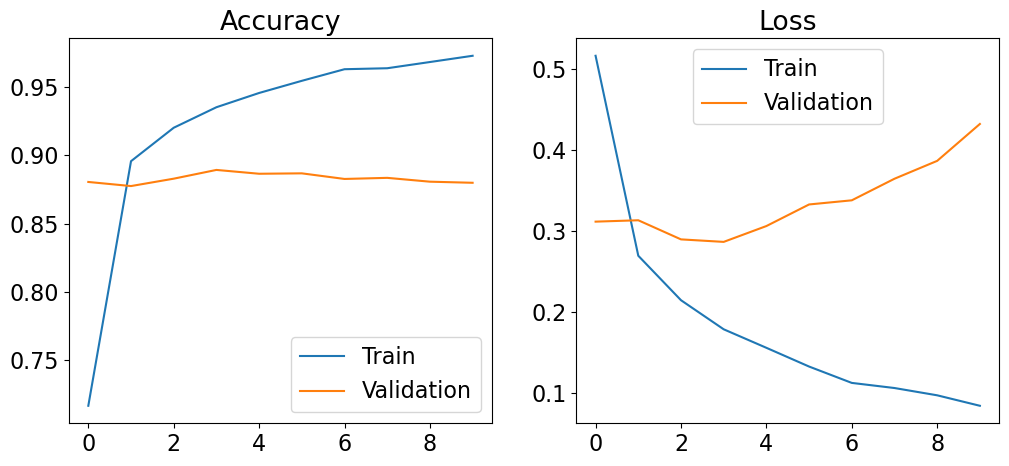

In [18]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(H.history['accuracy'], label = 'Train')
plt.plot(H.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(H.history['loss'], label = 'Train')
plt.plot(H.history['val_loss'], label = 'Validation')
plt.legend()
plt.title('Loss')

plt.show()

157/157 [==============================] - 55s 337ms/step
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2500
           1       0.86      0.92      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



Balanced accuracy score:  0.89




<Figure size 500x500 with 0 Axes>

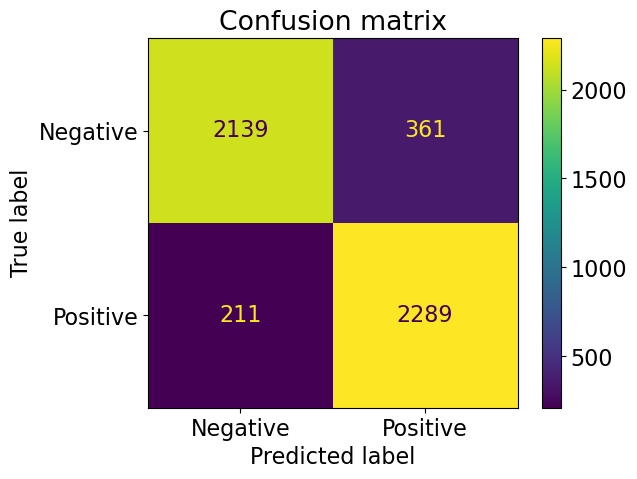

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
y_pred_proba = model.predict(test_pad)
y_pred = np.array([0 if proba < 0.5 else 1 for proba in y_pred_proba])

print(classification_report(y_test, y_pred))

print('\n')

print('Balanced accuracy score: ', np.round(balanced_accuracy_score(y_test, y_pred), 2))

print('\n')
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Negative', 'Positive'])
plt.figure(figsize = (5,5))
cm.plot()
plt.title('Confusion matrix')
plt.show()